In [27]:
# type: ignore
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


In [28]:
#dataset paths
train_dir = 'tomato_dataset/train'
val_dir = 'tomato_dataset/val'
test_dir = 'tomato_dataset/test'

In [29]:
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

In [30]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 15973 images belonging to 10 classes.
Found 10802 images belonging to 10 classes.
Found 6570 images belonging to 10 classes.


In [31]:
# Number of classes
num_classes = train_generator.num_classes

In [32]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False


In [33]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

In [34]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [36]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop]
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - accuracy: 0.4945 - loss: 1.5211 - val_accuracy: 0.7381 - val_loss: 0.8526
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 602s 1s/step - accuracy: 0.6830 - loss: 0.9322 - val_accuracy: 0.7937 - val_loss: 0.6495
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.7400 - loss: 0.7610 - val_accuracy: 0.8196 - val_loss: 0.5563
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.7663 - loss: 0.6862 - val_accuracy: 0.8315 - val_loss: 0.5067
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 749s 1s/step - accuracy: 0.7829 - loss: 0.6438 - val_accuracy: 0.8469 - val_loss: 0.4640
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.8019 - loss: 0.5933 - val_accuracy: 0.8592 - val_loss: 0.4322
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.8074 - loss: 0.5712 - val_accuracy: 0.8618 - val_loss: 0.4163
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 712s 1s/step - accuracy: 0.8198 - loss: 0.5284 - val_accu

In [37]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

206/206 ━━━━━━━━━━━━━━━━━━━━ 152s 740ms/step - accuracy: 0.8788 - loss: 0.3661
Test Loss: 0.3661
Test Accuracy: 0.8788


In [38]:
model.save('models/V2Net_tomato.keras')

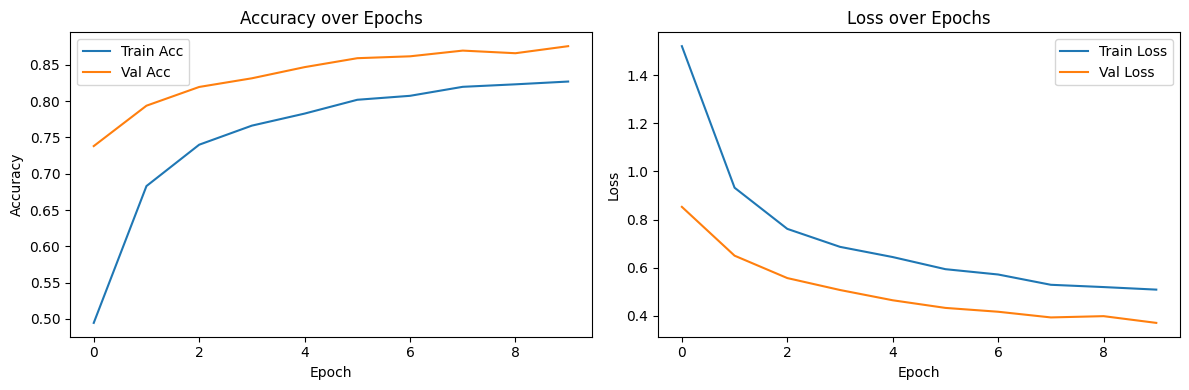

In [39]:
# Plot training history
plt.figure(figsize=(12, 4))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()